In [1]:
!pip install -q condacolab
import condacolab
condacolab.install()


✨🍰✨ Everything looks OK!


In [2]:
!conda install -c conda-forge face_recognition

Channels:
 - conda-forge
Platform: linux-64
Solving environment: \ | / done


==> WARNING: A newer version of conda exists. <==
    current version: 24.11.3
    latest version: 25.1.1

Please update conda by running

    $ conda update -n base -c conda-forge conda



# All requested packages already installed.



In [3]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time

In [4]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [5]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)

  # get photo data
  data = eval_js('takePhoto({})'.format(quality))
  # get OpenCV format image
  img = js_to_image(data)
  # grayscale img
  gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  print(gray.shape)
  # get face bounding box coordinates using Haar Cascade
  faces = face_cascade.detectMultiScale(gray)
  # draw face bounding box on image
  for (x,y,w,h) in faces:
      img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
  # save image
  cv2.imwrite(filename, img)

  return filename

<IPython.core.display.Javascript object>

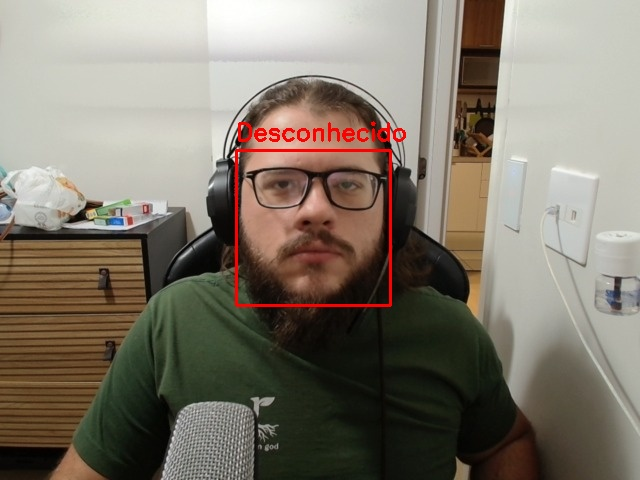

Deseja cadastrar este rosto? (s/n): s
Digite o nome da pessoa: Rafael
✅ Rosto de Rafael cadastrado com sucesso!


In [36]:
from google.colab import output
import cv2
import numpy as np
import base64
from IPython.display import display, Javascript, Image
import face_recognition
import pickle

# Carregar rostos conhecidos
try:
    with open("face_database.pkl", "rb") as f:
        face_db = pickle.load(f)
except FileNotFoundError:
    face_db = {}

known_face_encodings = list(face_db.values())
known_face_names = list(face_db.keys())

# Código JavaScript para capturar imagem da webcam
js = Javascript('''
    async function capture() {
        const div = document.createElement('div');
        const captureButton = document.createElement('button');
        captureButton.textContent = 'Capturar';
        div.appendChild(captureButton);

        const video = document.createElement('video');
        video.style.display = 'block';
        const stream = await navigator.mediaDevices.getUserMedia({video: true});

        document.body.appendChild(div);
        div.appendChild(video);
        video.srcObject = stream;
        await video.play();

        google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

        await new Promise((resolve) => captureButton.onclick = resolve);

        const canvas = document.createElement('canvas');
        canvas.width = video.videoWidth;
        canvas.height = video.videoHeight;
        canvas.getContext('2d').drawImage(video, 0, 0);
        stream.getVideoTracks()[0].stop();
        div.remove();
        return canvas.toDataURL('image/jpeg');
    }
''')

# Função para converter imagem JS base64 para OpenCV
def js_to_image(js_reply):
    img_data = js_reply.split(',')[1]
    img = np.frombuffer(base64.b64decode(img_data), dtype=np.uint8)
    img = cv2.imdecode(img, cv2.IMREAD_COLOR)
    return img

# Captura a imagem com a webcam
display(js)
data = eval_js('capture()')

# Converte para OpenCV
img = js_to_image(data)

# Realiza o reconhecimento facial
rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
face_locations = face_recognition.face_locations(rgb_img)
face_encodings = face_recognition.face_encodings(rgb_img, face_locations)

# Desenha as marcações (boxes e nomes) na imagem
for (top, right, bottom, left), face_encoding in zip(face_locations, face_encodings):
    matches = face_recognition.compare_faces(known_face_encodings, face_encoding)
    name = "Desconhecido"
    color = (0, 0, 255)

    if True in matches:
        matched_index = matches.index(True)
        name = known_face_names[matched_index]
        color = (0, 255, 0)

    cv2.rectangle(img, (left, top), (right, bottom), color, 2)
    cv2.putText(img, name, (left, top - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2)

# Exibe a imagem com as marcações
display(Image(data=cv2.imencode('.jpg', img)[1].tobytes()))

# Pergunta se deseja cadastrar o rosto detectado
if len(face_encodings) > 0:
    cadastrar = input("Deseja cadastrar este rosto? (s/n): ")
    if cadastrar.lower() == 's':
        novo_nome = input("Digite o nome da pessoa: ")
        face_db[novo_nome] = face_encodings[0]  # Armazena o rosto no dicionário
        known_face_encodings = list(face_db.values()) # Atualiza a lista de encodings
        known_face_names = list(face_db.keys()) # Atualiza a lista de nomes
        with open("face_database.pkl", "wb") as f:
            pickle.dump(face_db, f) # Salva o dicionário em um arquivo
        print(f"✅ Rosto de {novo_nome} cadastrado com sucesso!")
    else:
        print("Cadastro cancelado.")
else:
    print("❌ Nenhum rosto detectado. Tente novamente.")


<IPython.core.display.Javascript object>

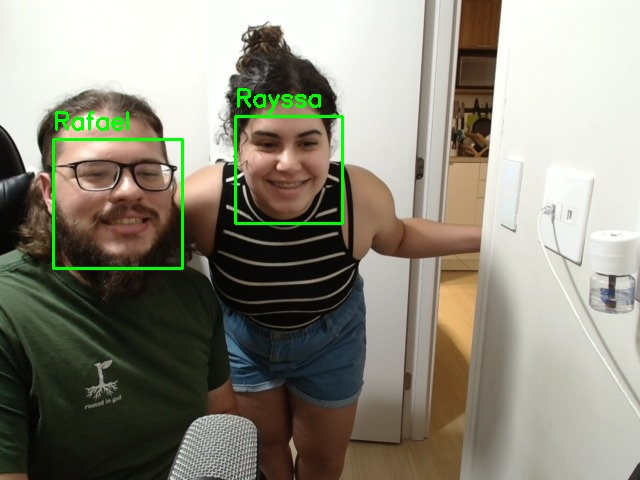

In [39]:
from google.colab import output
import cv2
import numpy as np
import base64
from IPython.display import display, Javascript, Image, HTML
import face_recognition
import pickle

# Carregar rostos conhecidos (mesmo código da versão anterior)
try:
    with open("face_database.pkl", "rb") as f:
        face_db = pickle.load(f)
except FileNotFoundError:
    face_db = {}

known_face_encodings = list(face_db.values())
known_face_names = list(face_db.keys())

# Código JavaScript para capturar imagem da webcam (mesmo código da versão anterior)
js = Javascript('''
    async function capture() {
        const div = document.createElement('div');
        const captureButton = document.createElement('button');
        captureButton.textContent = 'Capturar';
        div.appendChild(captureButton);

        const video = document.createElement('video');
        video.style.display = 'block';
        const stream = await navigator.mediaDevices.getUserMedia({video: true});

        document.body.appendChild(div);
        div.appendChild(video);
        video.srcObject = stream;
        await video.play();

        google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

        await new Promise((resolve) => captureButton.onclick = resolve);

        const canvas = document.createElement('canvas');
        canvas.width = video.videoWidth;
        canvas.height = video.videoHeight;
        canvas.getContext('2d').drawImage(video, 0, 0);
        stream.getVideoTracks()[0].stop();
        div.remove();
        return canvas.toDataURL('image/jpeg');
    }
''')

# Função para converter imagem JS base64 para OpenCV (mesmo código da versão anterior)
def js_to_image(js_reply):
    img_data = js_reply.split(',')[1]
    img = np.frombuffer(base64.b64decode(img_data), dtype=np.uint8)
    img = cv2.imdecode(img, cv2.IMREAD_COLOR)
    return img

# Captura a imagem com a webcam
display(js)
data = eval_js('capture()')

# Converte para OpenCV
img = js_to_image(data)

# Realiza o reconhecimento facial
rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
face_locations = face_recognition.face_locations(rgb_img)
face_encodings = face_recognition.face_encodings(rgb_img, face_locations)

# Desenha as marcações (boxes e nomes) na imagem
for (top, right, bottom, left), face_encoding in zip(face_locations, face_encodings):
    matches = face_recognition.compare_faces(known_face_encodings, face_encoding)
    name = "Desconhecido"
    color = (0, 0, 255)

    if True in matches:
        matched_index = matches.index(True)
        name = known_face_names[matched_index]
        color = (0, 255, 0)

    cv2.rectangle(img, (left, top), (right, bottom), color, 2)
    cv2.putText(img, name, (left, top - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2)

# Exibe a imagem com as marcações
display(Image(data=cv2.imencode('.jpg', img)[1].tobytes()))